# 1. Overview

This notebook contains the complete workflow for optimizing student–tutor assignments across tuition centres. The goals are:  

- **Scenario 1:** Minimize the number of active tutors while maximizing tutor preference satisfaction.  
- **Scenario 2:** Balance tutor workload while still prioritizing tutor preference satisfaction.  

Outputs include tables, charts, and key metrics to visualize results.


## Load Packages

In [1]:
import pandas as pd
from utils.model import TutorAssignmentModel
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10,6)

## Load Data

- Existing Student data is filtered; remove students who are not active 
- Assumption: inactive students are not attending tuition for current month

In [2]:
DATA_PATH = "./data/small_data.xlsx"

# Load specific sheets
new_student_info = pd.read_excel(DATA_PATH, sheet_name="New Students")
tutors = pd.read_excel(DATA_PATH, sheet_name="Tutor Information")
existing_student_info = pd.read_excel(DATA_PATH, sheet_name="Existing Students")
existing_student_info_filtered = existing_student_info[existing_student_info['active'] == True]

# 2. Decision Variables

- **`assign_vars[student, tutor]`** – Binary variable: 1 if student assigned to tutor, 0 otherwise.  
  Ensures unique student–tutor assignments and forms the core of the assignment model.  

- **`tutor_used[tutor]`** – Binary variable: 1 if tutor is active (assigned ≥ 1 student).  
  Used in Scenario 1 to reduce operational cost by minimizing total active tutors.  

- **Derived Variables:**  
  - `total_assigned[tutor] = existing + new students`  
  - `free_capacity[tutor] = max_capacity - total_assigned`  
  These are used in Scenario 2 to assess workload balance and utilization but are **not decision variables**.


# 3. Constraints

1. **Single Tutor per Student:** Each student is assigned to exactly one tutor.  
2. **Maximum Capacity Limit:** Total students per tutor (existing + new) ≤ MaxCapacity.  
3. **Skill Compatibility:** Students with extensive tutoring needs are only assigned to tutors with matching skills.  
4. **Tutor Activation:** `tutor_used = 1` if a tutor has ≥ 1 assigned student.  
5. **Workload Balance (Scenario 2 only):** Total students per tutor constrained to a range (30–90% of max capacity) to avoid idle tutors or overload.


# 4. Objective Function - Scenario 1

## Scenario 1 – Cost Efficiency + Preference Satisfaction

Maximize: β * Preference_Score - (1-β) * TutorUsed

- **Preference_Score:** Measures how well assignments match tutors’ preferred centres (1st choice = 1, 2nd choice = 0.5, others = 0).  
- **TutorUsed:** Minimizes total active tutors to reduce cost.  
- **Weight (β = 0.9):** Prioritizes preference satisfaction (90%) over cost efficiency (10%).  


### Optimization Process

In [ ]:
optimizer = TutorAssignmentModel(
        new_students=new_student_info,tutor_info=tutors,
        existing_students=existing_student_info_filtered,
        beta= 0.9,
        scenario=1
        )
optimizer.main_process()

### 5. Scenario 1 – Key Results


In [5]:
path = './results/'
task_1_assignments = pd.read_csv(f'{path}scenario_1_assignment_results.csv')
task_1_preference_report = pd.read_csv(f'{path}scenario_1_preference_report.csv')
task_1_tutor_summary = pd.read_csv(f'{path}scenario_1_tutor_summary.csv')

#### Tutor Utilization

- Bar chart: How many students are assigned to each tutor compared against tutor's max capacity

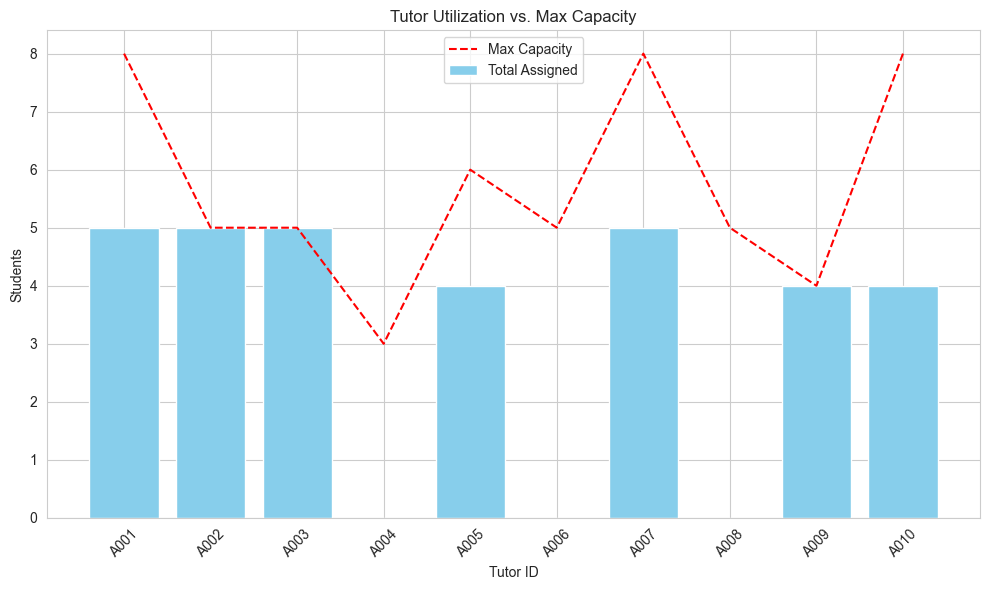

In [6]:
plt.figure()
plt.bar(task_1_tutor_summary["TutorID"],task_1_tutor_summary["TotalAssigned"], label="Total Assigned", color="skyblue")
plt.plot(task_1_tutor_summary["TutorID"],task_1_tutor_summary["MaxCapacity"], 'r--', label="Max Capacity")
plt.xlabel("Tutor ID")
plt.ylabel("Students")
plt.title("Tutor Utilization vs. Max Capacity")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Bar Chart: Each tutor's assigned student stacked against remaining capacity (Capacity utility provided)

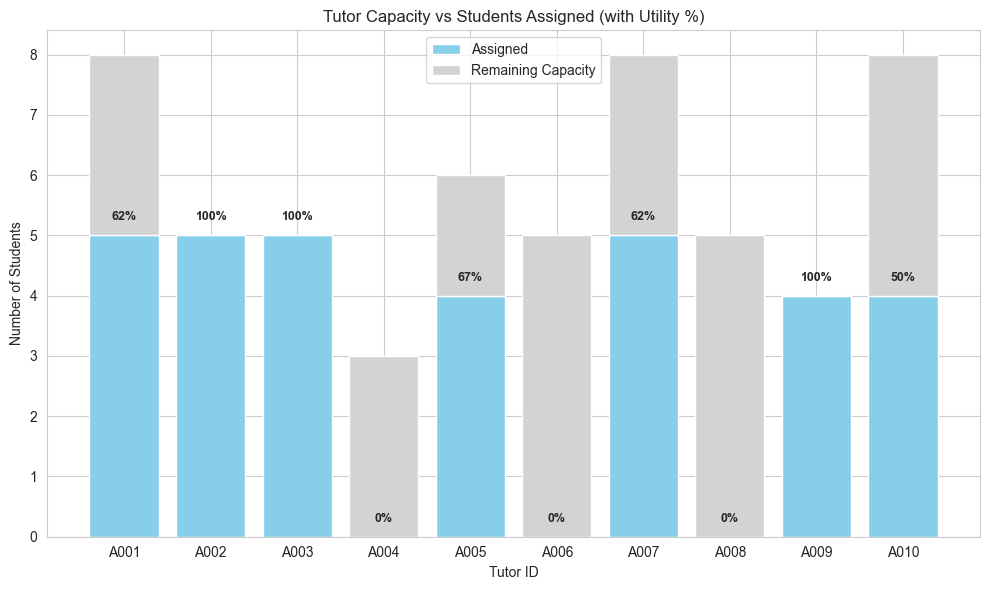

In [8]:
# Calculate utility as fraction of max capacity
task_1_tutor_summary["UtilityPct"] = (task_1_tutor_summary["TotalAssigned"] / 
                                      task_1_tutor_summary["MaxCapacity"] * 100)

plt.figure(figsize=(10,6))

# Stacked bars
plt.bar(task_1_tutor_summary["TutorID"], task_1_tutor_summary["TotalAssigned"], 
        label="Assigned", color="skyblue")
plt.bar(task_1_tutor_summary["TutorID"], 
        task_1_tutor_summary["MaxCapacity"] - task_1_tutor_summary["TotalAssigned"], 
        bottom=task_1_tutor_summary["TotalAssigned"], 
        label="Remaining Capacity", color="lightgray")

# Overlay utility percentage on top of bars
for idx, row in task_1_tutor_summary.iterrows():
        plt.text(
                row["TutorID"], row["TotalAssigned"] + 0.2, 
                f'{row["UtilityPct"]:.0f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.xlabel("Tutor ID")
plt.ylabel("Number of Students")
plt.title("Tutor Capacity vs Students Assigned (with Utility %)")
plt.legend()
plt.tight_layout()
plt.show()

Based on the above 2 chart(s):

**Observation(s)**
- Some tutors (A002, A003, A009) fully utilized → 100% capacity filled.
- Others (A004, A006, A008) idle → 0 new students assigned.

**Key Takeaway(s)** 
- Model prioritizes reducing active tutors → idle tutors save operational cost.
- Workload balance not prioritized → some tutors idle while others at max capacity.

- Stacked Bar Chart: Total Student assigned to different Tutors browken down into Existing VS New Students

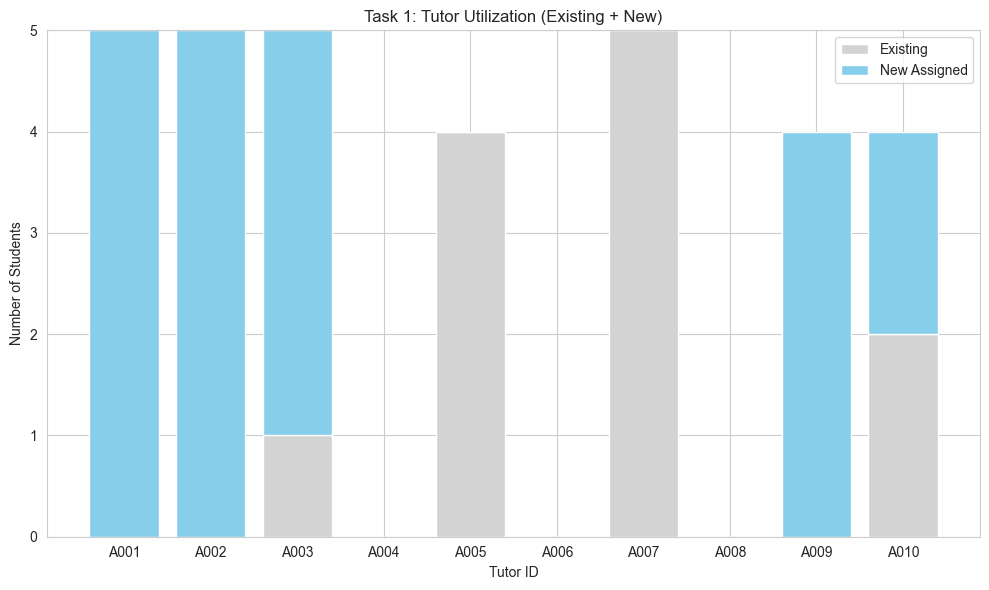

In [9]:
plt.bar(task_1_tutor_summary["TutorID"], task_1_tutor_summary["Existing"], label="Existing", color="lightgray")
plt.bar(task_1_tutor_summary["TutorID"], task_1_tutor_summary["NewAssigned"], bottom=task_1_tutor_summary["Existing"], label="New Assigned", color="skyblue")
plt.xlabel("Tutor ID")
plt.ylabel("Number of Students")
plt.title("Task 1: Tutor Utilization (Existing + New)")
plt.legend()
plt.tight_layout()
plt.show()

In [32]:
task_1_tutor_summary

,TutorID,NewAssigned,Existing,TotalAssigned,MaxCapacity,FreeCapacity,UtilityPct
0,A001,5.0,0,5.0,8,3.0,62.500000
1,A002,5.0,0,5.0,5,0.0,100.000000
2,A003,4.0,1,5.0,5,0.0,100.000000
3,A004,0.0,0,0.0,3,3.0,0.000000
4,A005,0.0,4,4.0,6,2.0,66.666667
5,A006,0.0,0,0.0,5,5.0,0.000000
6,A007,0.0,5,5.0,8,3.0,62.500000
7,A008,0.0,0,0.0,5,5.0,0.000000
8,A009,4.0,0,4.0,4,0.0,100.000000
9,A010,2.0,2,4.0,8,4.0,50.000000


Based on the Dataframe and the Bar Chart above:

***Observation(s)***
- High Utilization (100%)
    - Tutor A002, A003, A009 are fully utilised (no free capacity)
    - A002 and A009 reached full capacity from new assignments of students; prioritised to take new students
    - A003, despite already having one existing student, was still assigned four new students; smaller capacity makes it reach full utilisation faster.
- Moderate Utilization (50-67%):
    - Tutors A001, A005, and A010 have partial utilisation, balancing between existing and new students.
    - Exception: A001, whose 62.5% utilisation comes entirely from new students — the model effectively leveraged unused capacity.
    - Tutors A005 and A007 received no new students but maintained moderate utilisation from existing ones.
- Idle Tutors (0%)
    - Tutor A004, A006, A008 received no new or existing students
    - This aligns with the penalty term (tutor_used) in Scenario 1, which encourages minimising the number of active tutors to reduce cost.

**Key Takeaway(s)**
- Tutor with smaller capacities e.g. A002, A003, A009 tend to reach 100% capacity utlity easily 
- Idle tutors created from Scenario 1 results in more workload for other staff, with more than 50% tutors hitting more than half capacity

#### Free Capacity Distribution

- Bar Chart showing discrete counts of tutors for each free capacity value

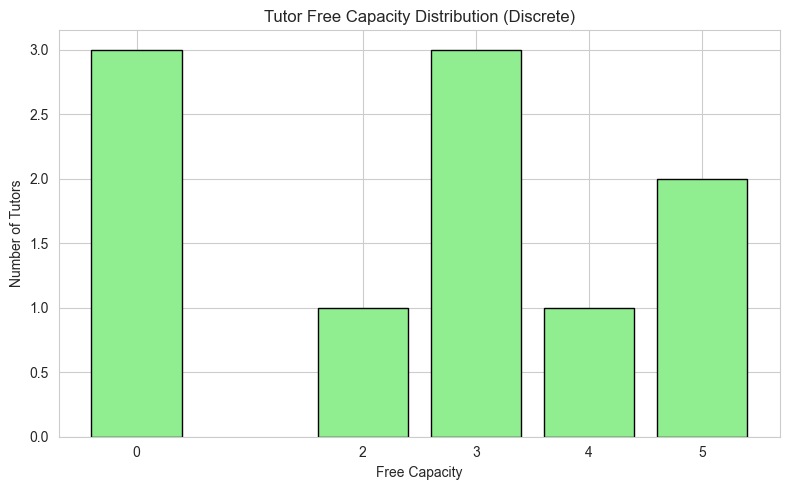

In [10]:
# Count number of tutors per exact free capacity
summary_counts = task_1_tutor_summary["FreeCapacity"].value_counts().sort_index()

# Vertical bar plot
plt.figure(figsize=(8,5))
plt.bar(summary_counts.index, summary_counts.values, color="lightgreen", edgecolor="black")
plt.xlabel("Free Capacity")
plt.ylabel("Number of Tutors")
plt.title("Tutor Free Capacity Distribution (Discrete)")

plt.xticks(summary_counts.index)  # ensure all integer free capacities shown
plt.tight_layout()
plt.show()


**Observation(s)**:
- Several tutors have zero free capacity (3 tutors fully utilized), while others have moderate to high free capacity (2–5 students).
- Some tutors remain completely idle (⅔ of them have 5 free capacity), reflecting unassigned workload.
- The distribution is more spread out compared to Scenario 2, showing extremes in tutor utilization.


**Key Takeaway(s)**:
- Penalty term pushes more students to certain tutors results 30% tutors being at max capacity 
- Same time causing more tutors to either have 0 or close to 0 workload results rightward skewed distribution
- Greater number of tutors with greater free capacity


#### Preference Satistifaction by Centre

- DataFrame: Showing tutors assigned to students whose centre matches their preferences

In [29]:
task_1_preference_report

,StudentID,StudentCentre,TutorID,TutorPref1,TutorPref2,MatchPref
0,S0001,East,A001,East,North,True
1,S0002,West,A003,West,North,True
2,S0003,Central,A009,Central,North,True
3,S0004,East,A001,East,North,True
4,S0005,Central,A009,Central,North,True
5,S0006,North,A001,East,North,True
6,S0007,East,A001,East,North,True
7,S0008,Central,A009,Central,North,True
8,S0009,North,A002,North,East,True
9,S0010,West,A003,West,North,True


- Bar Chart: Proportion of student–tutor assignments where the tutor’s preferred centre includes the student’s tuition centre

Overall Tutor Preference Satisfaction: 100.0%


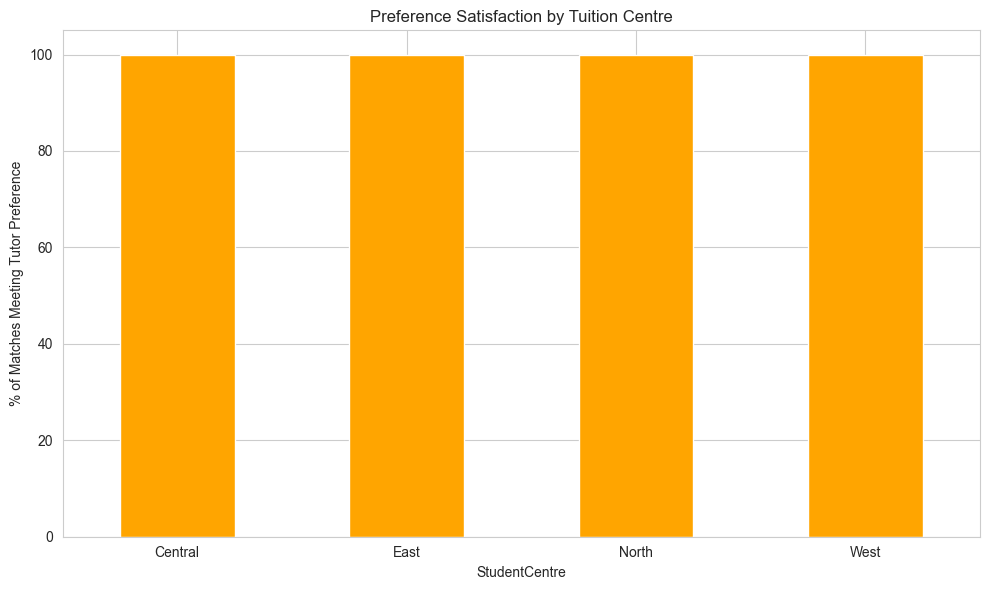

In [12]:
pref_rate = task_1_preference_report["MatchPref"].mean() * 100
print(f"Overall Tutor Preference Satisfaction: {pref_rate:.1f}%")

pref_by_centre = task_1_preference_report.groupby("StudentCentre")["MatchPref"].mean().mul(100)
pref_by_centre.plot(kind='bar', color='orange')
plt.ylabel("% of Matches Meeting Tutor Preference")
plt.title("Preference Satisfaction by Tuition Centre")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


**Key Takeaway(s)**:
- All student in each centre are assigned to tutors who prefer teaching in that particular centre
Scenario 1 objective successfully maximizes tutor preference while still minimizing the number of active tutors.
- All the assignments also happens to match all the tutors’ 1st preferred tuition centre 
- Tutors’ preferences are scored:
    - Preferred Centre 1 → score = 1
    - Preferred Centre 2 → score = 0.5
    - Otherwise → score = 0
- β parameter prioritizing assignment of student to tutor that matches his preferred choice: tuition centre
- Model rewarded by assigning more students to tutor whose tuition centre matches tutor’s first choice


#### Assignment Matrix

- Visualise assignment of new students to different tutors
    - No new student assigned to more than 1 tutor

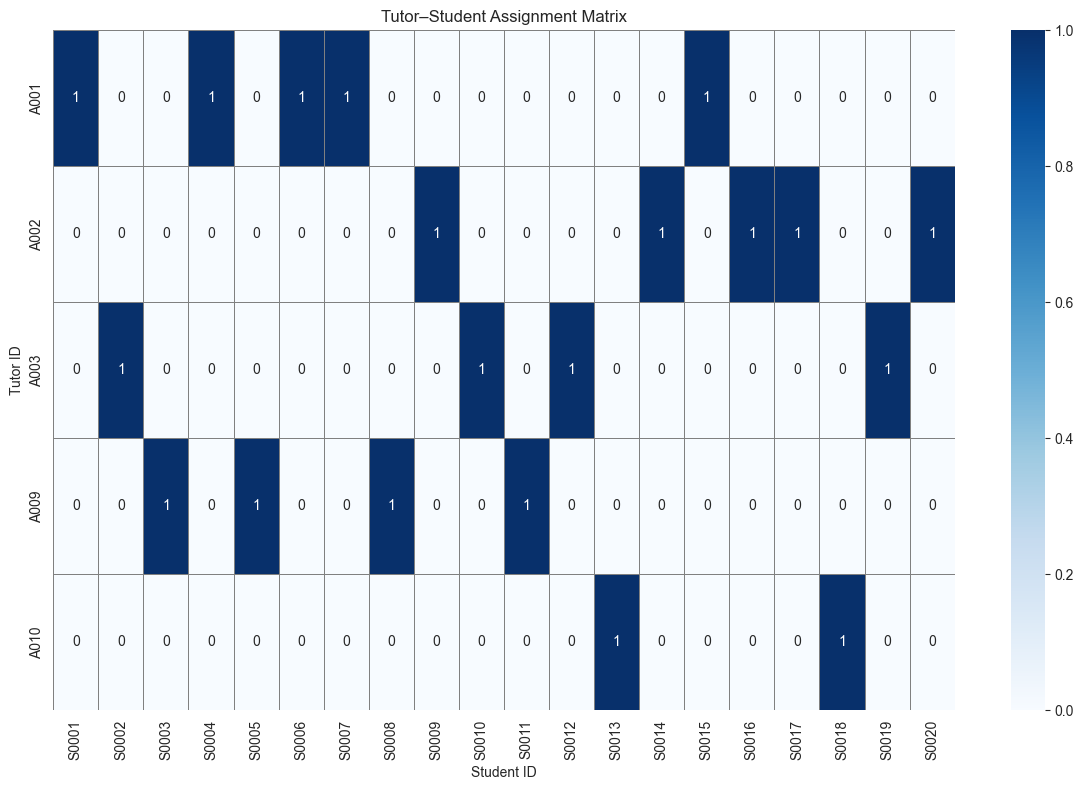

In [13]:
pivot = task_1_assignments.pivot_table(index="TutorID", columns="StudentID", aggfunc=len, fill_value=0)

plt.figure(figsize=(12,8))
sns.heatmap(pivot, cmap="Blues", cbar=True, linewidths=0.5, linecolor='gray', annot=True, fmt="d")
plt.xlabel("Student ID")
plt.ylabel("Tutor ID")
plt.title("Tutor–Student Assignment Matrix")
plt.tight_layout()
plt.show()

## Scenario 2 – Balanced Workload + Preference Satisfaction

Maximize: β * Preference_Score - (1-β) * Workload_Imbalance

- **Workload_Imbalance:** Sum of scaled free capacity per tutor (`FreeCapacity / MaxCapacity`). Normalizes for tutors with different max capacities.  
- Promotes fairness:  
  - Tutors with small max loads are not overloaded.  
  - Tutors with large max loads are not underutilized.  
- **Weight (β = 0.9):** Preference satisfaction remains the main priority, with 10% focus on balancing workload.



### Optimization Process

In [ ]:
# Scenario 2
optimizer = TutorAssignmentModel(
        new_students=new_student_info,tutor_info=tutors,
        existing_students=existing_student_info_filtered,
        beta= 0.9,
        scenario=2
        )
optimizer.main_process()

### 6. Scenario 2 – Key Results

In [15]:
path = './results/'
task_2_assignments = pd.read_csv(f'{path}scenario_2_assignment_results.csv')
task_2_preference_report = pd.read_csv(f'{path}scenario_2_preference_report.csv')
task_2_tutor_summary = pd.read_csv(f'{path}scenario_2_tutor_summary.csv')

#### Tutor Utilization

- Bar chart: How many students are assigned to each tutor compared against tutor's max capacity

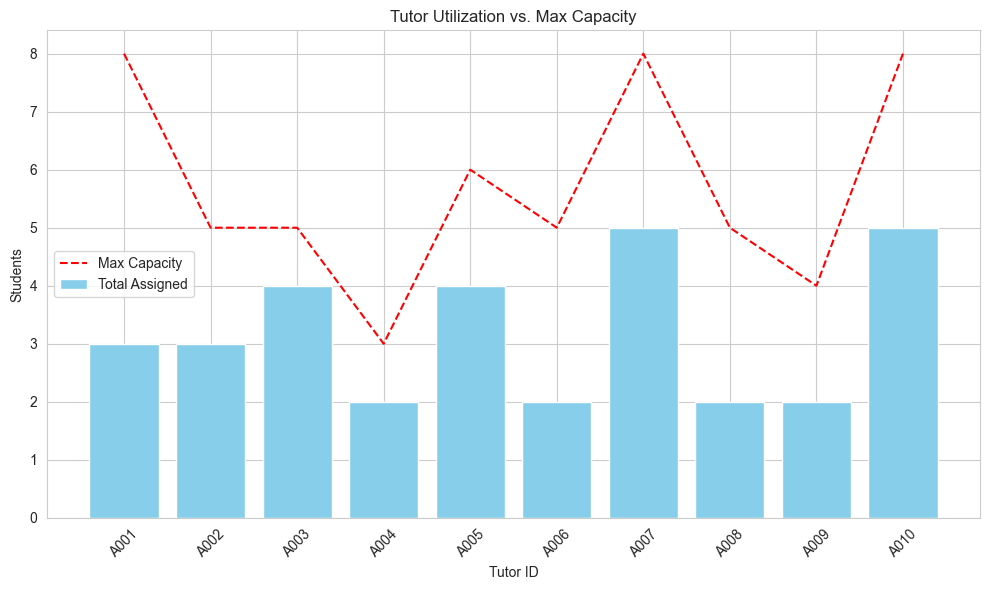

In [16]:
plt.figure()
plt.bar(task_2_tutor_summary["TutorID"],task_2_tutor_summary["TotalAssigned"], label="Total Assigned", color="skyblue")
plt.plot(task_2_tutor_summary["TutorID"],task_2_tutor_summary["MaxCapacity"], 'r--', label="Max Capacity")
plt.xlabel("Tutor ID")
plt.ylabel("Students")
plt.title("Tutor Utilization vs. Max Capacity")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Bar Chart: Each tutor's assigned student stacked against remaining capacity

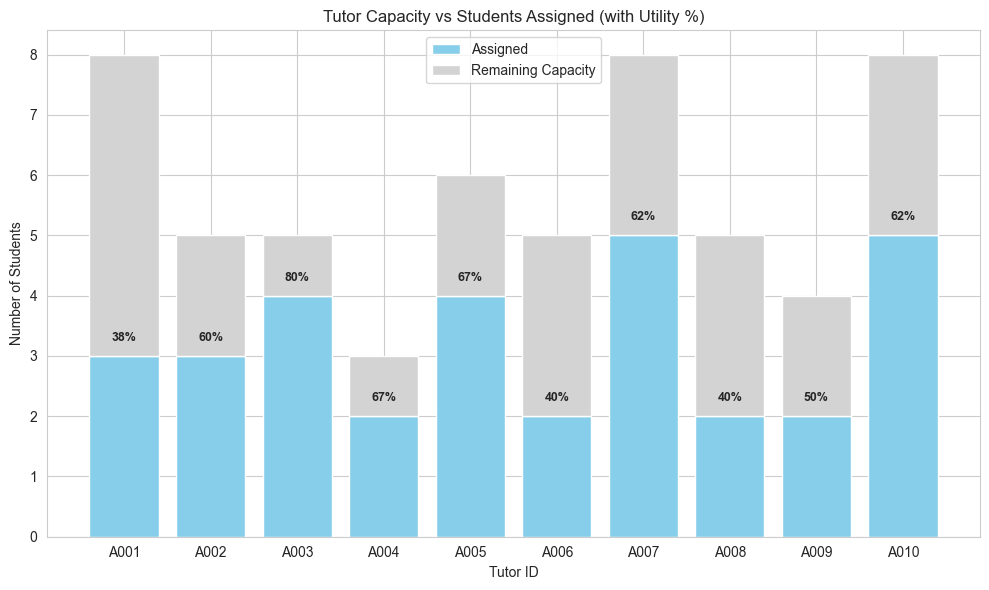

In [17]:

# Calculate utility as fraction of max capacity
task_2_tutor_summary["UtilityPct"] = (task_2_tutor_summary["TotalAssigned"] / 
                                      task_2_tutor_summary["MaxCapacity"] * 100)

plt.figure(figsize=(10,6))

# Stacked bars
plt.bar(task_2_tutor_summary["TutorID"], task_2_tutor_summary["TotalAssigned"], 
        label="Assigned", color="skyblue")
plt.bar(task_2_tutor_summary["TutorID"], 
        task_2_tutor_summary["MaxCapacity"] - task_2_tutor_summary["TotalAssigned"], 
        bottom=task_2_tutor_summary["TotalAssigned"], 
        label="Remaining Capacity", color="lightgray")

# Overlay utility percentage on top of bars
for idx, row in task_2_tutor_summary.iterrows():
        plt.text(
                row["TutorID"], row["TotalAssigned"] + 0.2, 
                f'{row["UtilityPct"]:.0f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.xlabel("Tutor ID")
plt.ylabel("Number of Students")
plt.title("Tutor Capacity vs Students Assigned (with Utility %)")
plt.legend()
plt.tight_layout()
plt.show()

*Based on the 2 above Bar Charts*:

**Observations**:
- Tutors show varied utilization levels depending on their assigned load.
- Moderately utilized tutors: A001, A004, A005, A006, A007, A008, A009, and A010 — utilization ranges between 38–67%.
- A003 has a relatively high utilization rate (~80%).
- No tutors are left idle — every tutor has at least some students assigned.

**Key Takeaway(s)**:
- A003’s high utilization is due to its relatively small maximum capacity.
- Workload is fairly distributed, supported by the Workload_Imbalance penalty term in Scenario 2.
- No extreme workload cases — no idle tutors or tutors near full capacity, except A003 compared to Scenario 1
- A001 has the lowest utilisation rate as he does not have existing students but high Max Capacity



- Bar chart showing the Workload utilization against Average Tutor Utilisation

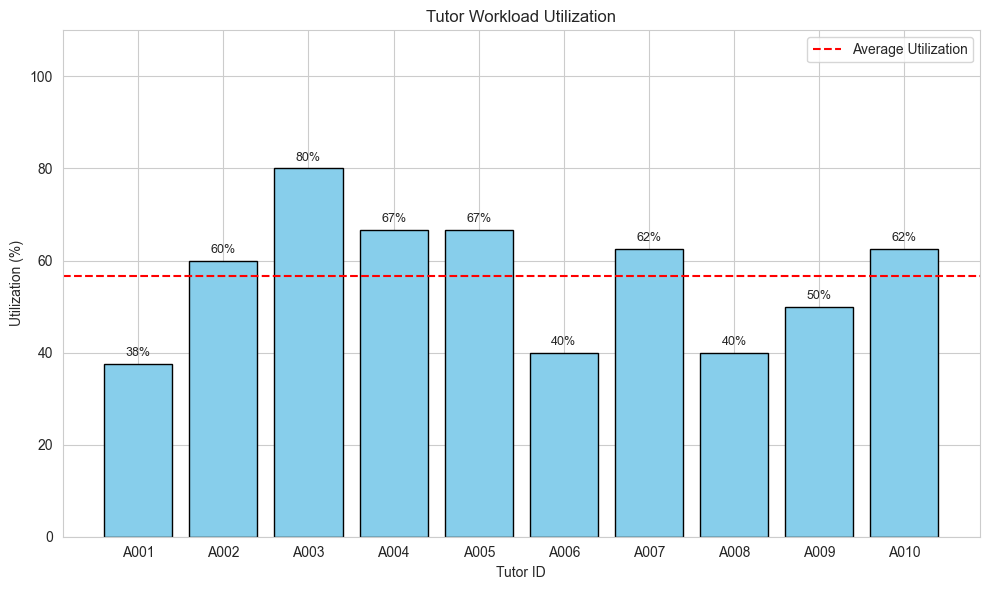

In [18]:
# Calculate utilization as percentage
task_2_tutor_summary['Utilization'] = task_2_tutor_summary['TotalAssigned'] / task_2_tutor_summary['MaxCapacity'] * 100

plt.figure(figsize=(10,6))
bars = plt.bar(
    task_2_tutor_summary["TutorID"], 
    task_2_tutor_summary["Utilization"], 
    color="skyblue", edgecolor="black")

# Average utilization line
plt.axhline(y=task_2_tutor_summary["Utilization"].mean(), color='red', linestyle='--', label='Average Utilization')

# Add numbers on top of each bar as percentages
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, height + 1, 
        f'{height:.0f}%', ha='center', va='bottom', fontsize=9)

plt.xlabel("Tutor ID")
plt.ylabel("Utilization (%)")
plt.title("Tutor Workload Utilization")
plt.ylim(0,110)  # slightly higher to accommodate labels
plt.legend()
plt.tight_layout()
plt.show()



In [33]:
task_2_tutor_summary

,TutorID,NewAssigned,Existing,TotalAssigned,MaxCapacity,FreeCapacity
0,A001,3.0,0,3.0,8,5.0
1,A002,3.0,0,3.0,5,2.0
2,A003,3.0,1,4.0,5,1.0
3,A004,2.0,0,2.0,3,1.0
4,A005,0.0,4,4.0,6,2.0
5,A006,2.0,0,2.0,5,3.0
6,A007,0.0,5,5.0,8,3.0
7,A008,2.0,0,2.0,5,3.0
8,A009,2.0,0,2.0,4,2.0
9,A010,3.0,2,5.0,8,3.0


From the data frame and Bar Chart above, 

**Observation(s)**
- Tutors display mized utilization, ranging from low (e.g. A001,A006,A008 around 40%) to high (A003 near 80%)
- Varation is due to scaled impact of tutor capacity -> tutor with smaller max capacity e.g. A003 reaches higher utilization
- No tutors are idle, workload imbalance penalty forces assignment of students to tutors 
- Average utilization is close to 60% 

**Key Takeaway(s)**
- Scenario 2 achieves better fairness -> distributing students more evenly across tutors
- Workload Imbalance penalty ensures proportional fairness i.e. tutor with higher capacities arent under utilized; lower capacity overloaded
- Exceptions: A001 only has 3 students despite 8 capacity
- Possible reasons why there variations in utilization is due to scaling by tutor capacity in penalty term and secondary priority given to workload balancing 
- Overall model balance high preference satisfaction for tutors and improved capacity fairness compared to Scenario 1 

- Stacked Bar Chart: Total Student assigned to different Tutors browken down into Existing VS New Students

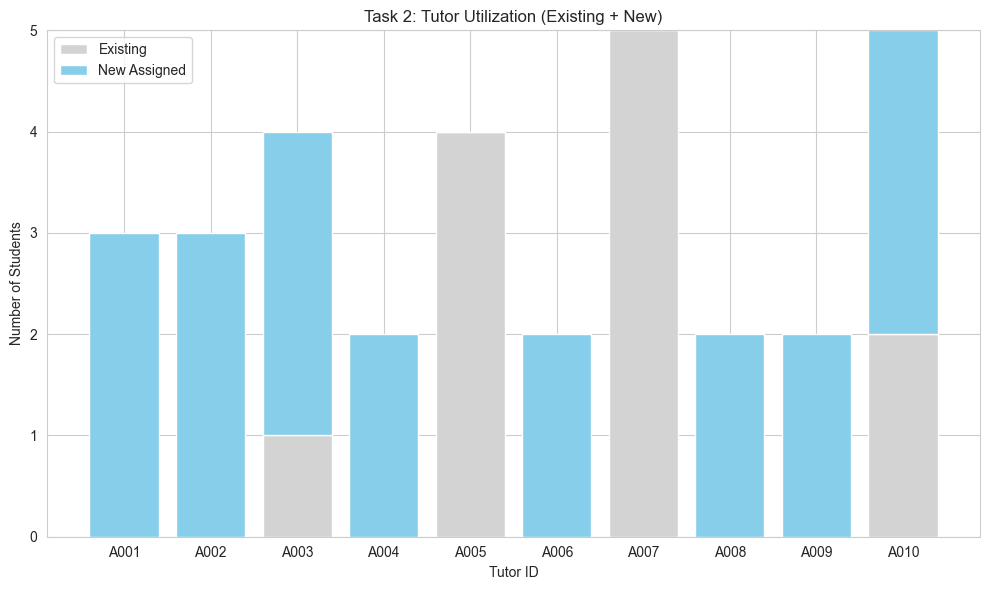

In [19]:
plt.bar(task_2_tutor_summary["TutorID"], task_2_tutor_summary["Existing"], label="Existing", color="lightgray")
plt.bar(task_2_tutor_summary["TutorID"], task_2_tutor_summary["NewAssigned"], bottom=task_2_tutor_summary["Existing"], label="New Assigned", color="skyblue")
plt.xlabel("Tutor ID")
plt.ylabel("Number of Students")
plt.title("Task 2: Tutor Utilization (Existing + New)")
plt.legend()
plt.tight_layout()
plt.show()


In [35]:
task_2_tutor_summary

,TutorID,NewAssigned,Existing,TotalAssigned,MaxCapacity,FreeCapacity
0,A001,3.0,0,3.0,8,5.0
1,A002,3.0,0,3.0,5,2.0
2,A003,3.0,1,4.0,5,1.0
3,A004,2.0,0,2.0,3,1.0
4,A005,0.0,4,4.0,6,2.0
5,A006,2.0,0,2.0,5,3.0
6,A007,0.0,5,5.0,8,3.0
7,A008,2.0,0,2.0,5,3.0
8,A009,2.0,0,2.0,4,2.0
9,A010,3.0,2,5.0,8,3.0


From the above chart and dataframe, 

**Observation(s)**
- Tutors previously idle in Scenario 1 i.e. A004, A006, A008 received new students
- All the tutors have free capacity; some more than others 
- Possible that this scenario due to greater priority assigning students to tutors with tutor's preferred tuition centres 

**Key Takeaway(s)**
- Scenario 2 prevents idle tutors; spread workload evenly
- Small deviations exist deu to prioritizing preference satisfaction

### Free Capacity Distribution

- Bar Chart showing discrete counts of tutors for each free capacity value

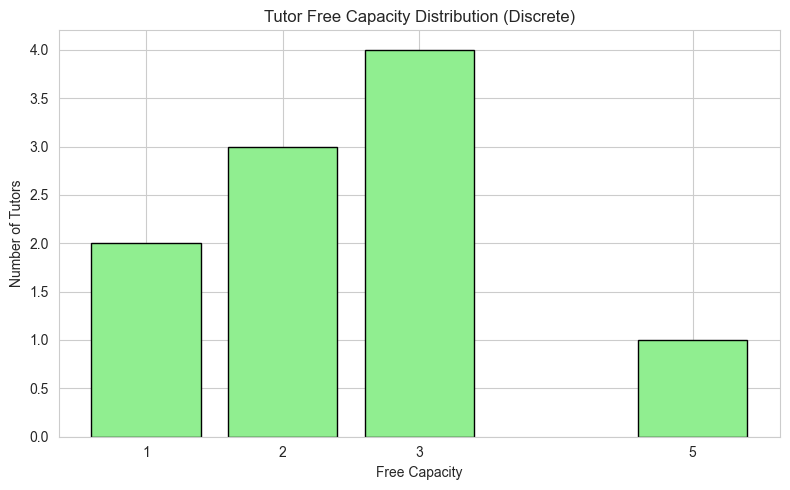

In [20]:
# Count number of tutors per exact free capacity
summary_counts = task_2_tutor_summary["FreeCapacity"].value_counts().sort_index()

# Vertical bar plot
plt.figure(figsize=(8,5))
plt.bar(summary_counts.index, summary_counts.values, color="lightgreen", edgecolor="black")
plt.xlabel("Free Capacity")
plt.ylabel("Number of Tutors")
plt.title("Tutor Free Capacity Distribution (Discrete)")

plt.xticks(summary_counts.index)  # ensure all integer free capacities shown
plt.tight_layout()
plt.show()


***Observation(s)***:
- Most tutors have moderate free capacity (2–3 students), showing a fairly balanced student distribution.
- Only 2 tutors have very low free capacity (1 student), and 1 tutor has higher free capacity (5 students).
- No tutor is completely idle (0 free capacity), unlike Scenario 1.

***Key Takeaway(s)***:
- The distribution is slightly left-skewed, meaning most tutors have lower free capacity.
- Workload is fairly balanced, with the majority of tutors having 1–3 units of free capacity.
- Fewer idle tutors contribute to more tutors having smaller remaining capacity.


#### Preference Satisfaction by Centre

- Bar Chart: Proportion of student–tutor assignments where the tutor’s preferred centre includes the student’s tuition centre

Overall Tutor Preference Satisfaction: 100.0%


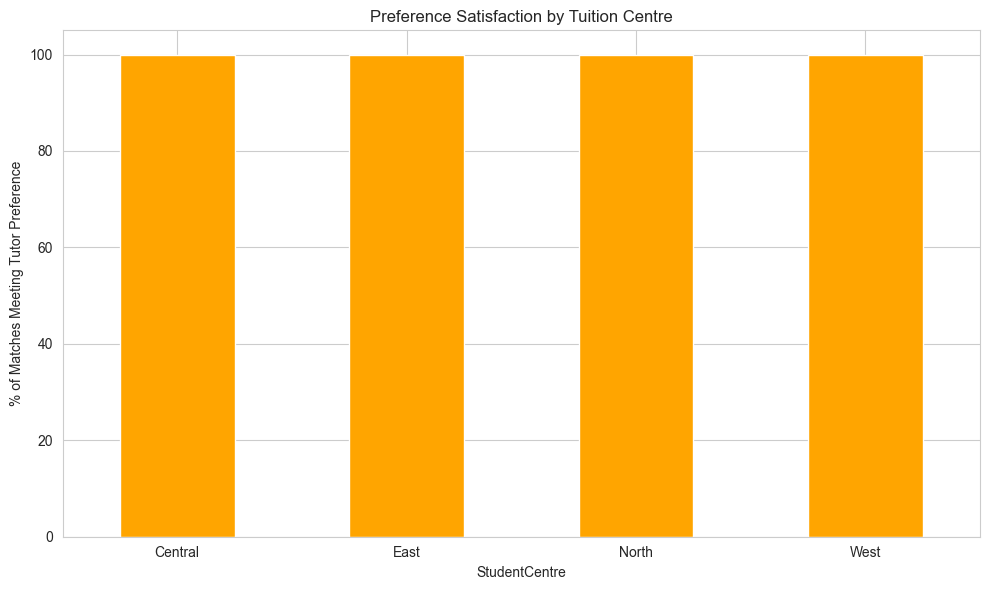

In [22]:
pref_rate = task_2_preference_report["MatchPref"].mean() * 100
print(f"Overall Tutor Preference Satisfaction: {pref_rate:.1f}%")

pref_by_centre = task_2_preference_report.groupby("StudentCentre")["MatchPref"].mean().mul(100)
pref_by_centre.plot(kind='bar', color='orange')
plt.ylabel("% of Matches Meeting Tutor Preference")
plt.title("Preference Satisfaction by Tuition Centre")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


- DataFrame: Showing tutors assigned to students whose centre matches their preferences

In [30]:
task_2_preference_report

,StudentID,StudentCentre,TutorID,TutorPref1,TutorPref2,MatchPref
0,S0001,East,A006,East,Central,True
1,S0002,West,A010,West,North,True
2,S0003,Central,A008,Central,West,True
3,S0004,East,A001,East,North,True
4,S0005,Central,A008,Central,West,True
5,S0006,North,A001,East,North,True
6,S0007,East,A001,East,North,True
7,S0008,Central,A009,Central,North,True
8,S0009,North,A002,North,East,True
9,S0010,West,A010,West,North,True


From the above Dataframe, Bar chart: 

**Key Takeaway(s)**:
- All student in each centre are assigned to tutors who prefer teaching in that particular centre
- Scenario 2 objective successfully maximizes tutor preference while still minimizing the number of active tutors.
- All the assignments also happens to match all the tutors’ 1st preferred tuition centre 
- Tutors’ preferences are scored:
    - Preferred Centre 1 → score = 1
    - Preferred Centre 2 → score = 0.5
    - Otherwise → score = 0
- β parameter prioritizing assignment of student to tutor that matches his preferred choice: tuition centre
- Model rewarded by assigning more students to tutor whose tuition centre matches tutor’s first choice


#### Assignment Matrix

- Visualises assignment of new students to different tutors (sanity check that 1 student - 1 tutor rule met)

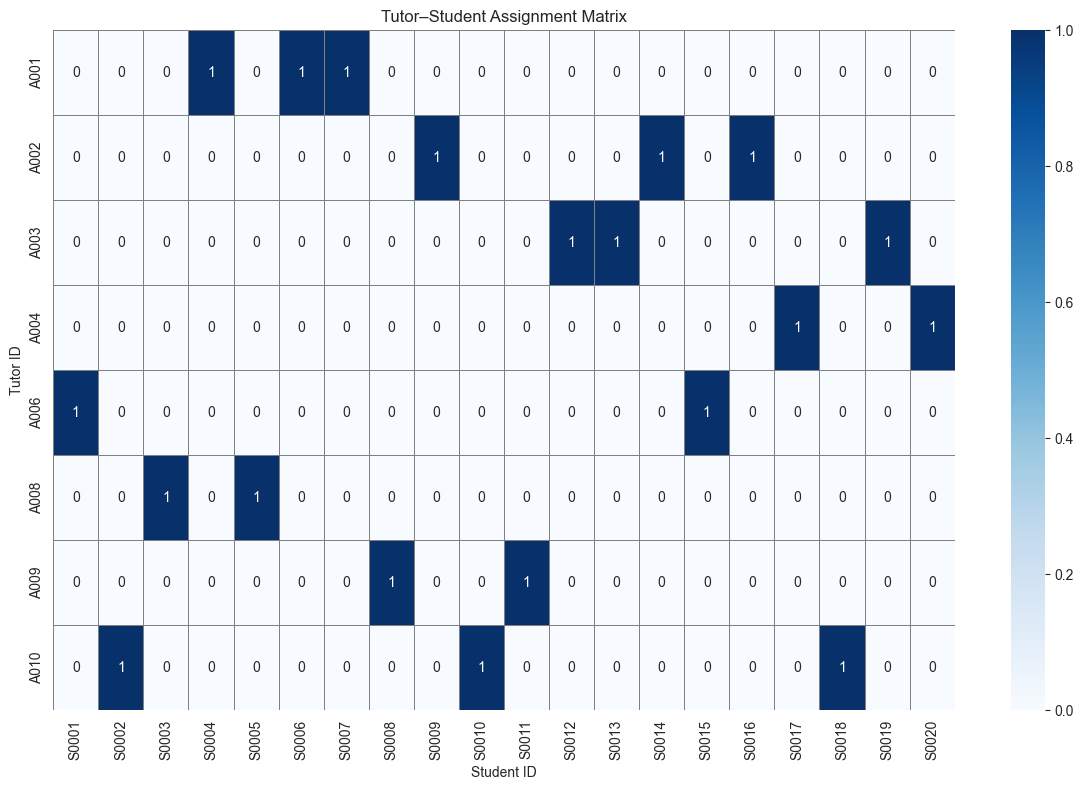

In [23]:
pivot = task_2_assignments.pivot_table(index="TutorID", columns="StudentID", aggfunc=len, fill_value=0)

plt.figure(figsize=(12,8))
sns.heatmap(pivot, cmap="Blues", cbar=True, linewidths=0.5, linecolor='gray', annot=True, fmt="d")
plt.xlabel("Student ID")
plt.ylabel("Tutor ID")
plt.title("Tutor–Student Assignment Matrix")
plt.tight_layout()
plt.show()

From the above Assigned Matrix,

**Observation**:
- Assignment does not violate: Each student can only be assigned 1 tutor

#### Comparing Efficiency (Total tutors used) VS Avg Free Capacity (Workload Balance)

- Bar chart comparing Scenario 1 and Scenario 2 in terms of tutors used and average free capacity (Attached the actual values below)

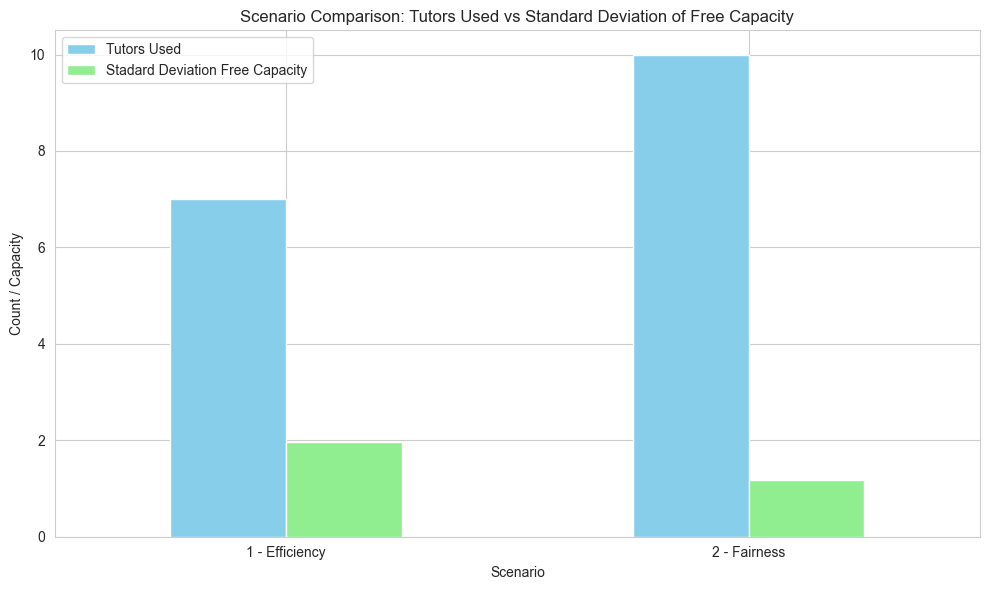

In [24]:
try:
    task_2_tutor_summary = pd.read_csv("./results/scenario_2_tutor_summary.csv")
    comp = pd.DataFrame({
        "Scenario": ["1 - Efficiency", "2 - Fairness"],
        "Tutors Used": [
            (task_1_tutor_summary["TotalAssigned"] > 0).sum(),
            (task_2_tutor_summary["TotalAssigned"] > 0).sum()
        ],
        "Stadard Deviation Free Capacity": [
            task_1_tutor_summary["FreeCapacity"].std(),
            task_2_tutor_summary["FreeCapacity"].std()
        ]
    })
    comp.set_index("Scenario").plot(kind="bar", color=["skyblue","lightgreen"])
    plt.title("Scenario Comparison: Tutors Used vs Standard Deviation of Free Capacity")
    plt.ylabel("Count / Capacity")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
except FileNotFoundError:
    print("Scenario 2 data not found. Skipping scenario comparison.")

- Values shown in the above visualisation

In [25]:
comp

,Scenario,Tutors Used,Stadard Deviation Free Capacity
0,1 - Efficiency,7,1.957890
1,2 - Fairness,10,1.178511


From the Scenario Comparison chart, 

**Observation(s)**:
- Tutors Used: Scenario 1 uses 7 tutors, while Scenario 2 activates all 10 tutors.
- Workload Spread: Scenario 1 has a higher standard deviation of free capacity (1.96) compared to Scenario 2 (1.18), indicating more variability in tutor workloads.

**Key Takeaway(s)**:
- Scenario 1 prioritizes cost efficiency → fewer active tutors, but some tutors are either idle (a lot of free capacity) or overloaded.
- Scenario 2 promotes fairness → all tutors are utilized, and workloads are more evenly distributed.
- Lower standard deviation in Scenario 2 shows workload is balanced across tutors, supporting the intended effect of the Workload_Imbalance penalty.
